# 04-1. 로지스틱 회귀
목표: 로지스틱 회귀 알고리즘을 배우고 이진 분류 문제에서 클래스 확률 예측하기


---





목표: 로지스틱 회귀 알고리즘을 배우고 이진 분류 문제에서 클래스 확률 예측하기


---

## 문제 상황 #1
- 럭키백에 들어간 생선의 특성이 주어졌을 때 총 7개 생선에 대한 확률을 출력해야 함
- 해결방법: k-최근접 이웃 분류기를 이요해 이웃 클래스의 비율을 확률로 계산함



In [63]:
# 데이터 준비하기
import pandas as pd
fish = pd.read_csv('https://bit.ly/fish_csv')
# 처음 5개 행 출력하기
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


In [64]:
# 생선 종류 파악하기
print(pd.unique(fish['Species']))

['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']


In [65]:
# Species을 타깃으로, 나머지 열은 입력 데이터로 사용하기
fish_input = fish[['Weight', 'Length', 'Diagonal', 'Height', 'Width']].to_numpy()

- 데이터프레임에서 열 여러개를 선택하면 새로운 데이터프레임이 반환됨
- 이를 numpy 배열로 변환함

In [66]:
# 샘플 5개의 입력 데이터 확인하기
print(fish_input[:5])

[[242.      25.4     30.      11.52     4.02  ]
 [290.      26.3     31.2     12.48     4.3056]
 [340.      26.5     31.1     12.3778   4.6961]
 [363.      29.      33.5     12.73     4.4555]
 [430.      29.      34.      12.444    5.134 ]]


In [67]:
# 타깃 데이터 설정하기
fish_target = fish['Species'].to_numpy()

In [68]:
# 훈련 데이터와 테스트 데이터 분류하기
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
  fish_input, fish_target, random_state=42)

# 데이터 표준화 전처리
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

## K-최근접 이웃 분류기의 확률 예측

In [69]:
# 모델 훈련하기
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(train_scaled, train_target)

# 훈련 세트와 테스트 세트의 점수
print(kn.score(train_scaled, train_target))
print(kn.score(test_scaled, test_target))

0.8907563025210085
0.85


- 다중 분류: 타깃 데이터에 2개 이상의 클래스가 포함된 문제
- 사이킷런에서는 타깃값을 0/1뿐만 아니라 문자열로 된 타깃값도 사용 가능
- 주의! 타깃값의 순서가 전달된 순서가 아닌 알파벳 순으로 매겨짐

In [70]:
print(kn.classes_)

# 테스트 세트의 첫 5개 샘플 예측하기
print(kn.predict(test_scaled[:5]))

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']
['Perch' 'Smelt' 'Pike' 'Perch' 'Perch']


- 사이킷런의 분류 모델은 predict_proba() 메서드로 클래스별 확률값을 반환함

In [71]:
# 테스트 세트의 첫 5개 샘플 확률값 계산하기
import numpy as np
proba = kn.predict_proba(test_scaled[:5])

# 확률값 소수점 4자리까지 표기
print(np.round(proba, decimals=4))

[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]


- 이때 출력 순서는 classes_속성과 같음, 즉 알파벳 순서

In [72]:
# 네번째 샘플의 주변 이웃 확인하기
distances, indexes = kn.kneighbors(test_scaled[3:4])
print(train_target[indexes])

[['Roach' 'Perch' 'Perch']]


## 문제 상황  #2
- 3개의 최근접 이웃을 사용하기 때문에 확률값이 0, 1/3, 2/3, 1이 전부임
- 이웃한 샘플의 클래스 비율이므로 항상 정해진 확률값만 출력
- 해결방법: 로지스틱 회귀로 확률 예측하기

## 로지스틱 회귀
- 로지스틱 회귀: 선형 회귀와 동일하게 선형 방정식을 학습하는 분류 모델
- $z = a \times (Weight) + b \times (Length) + c \times (Diagonal) + d \times (Height) + e \times (Width) + f$
- z는 어떤 수도 가능하지만 우리가 필요한건 확률이기 때문에 0~1 값이 필요
- 시그모이드 함수(로지스틱 함수): z가 아주 작은 수일 때는 0, 아주 큰 수일 때는 1로 변환함
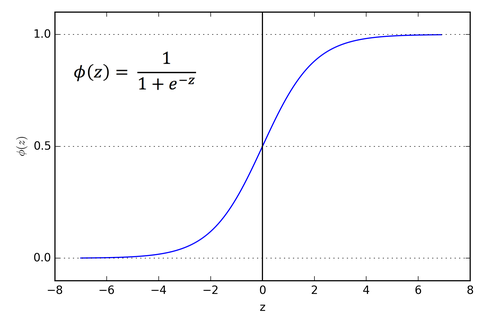


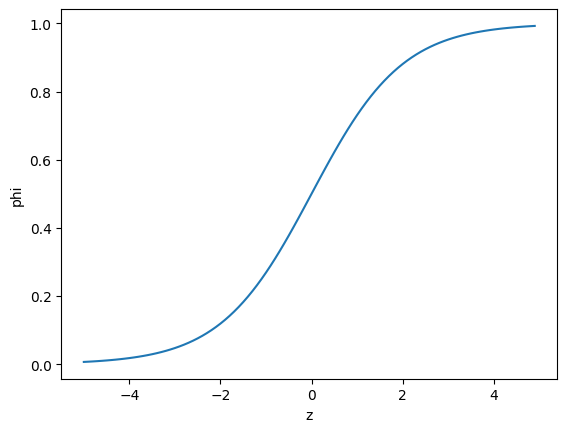

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# -5~5를 0.1 간격으로 한 배열 생성
z = np.arange(-5, 5, 0.1)

# 시그모이드 함수
phi = 1 / (1 + np.exp(-z))
plt.plot(z, phi)
plt.xlabel('z')
plt.ylabel('phi')
plt.show()

## 로지스틱 회귀로 이진 분류 수행하기
1. 간단한 이진 분류 연습해보기
- 시그모이드 함수의 출력이 0.5보다 작으면 음성 클래스, 0.5보다 크면 양성 클래스
- 불리안 인덱싱: 넘파이 배열은 True, False 값으로 행을 선택할 수 있음

In [74]:
char_arr = np.array(['A', 'B', 'C', 'D', 'E'])
print(char_arr[[True, False, True, False, False]])

['A' 'C']


- 위와 같은 방식으로 훈련 세트에서 도미(Bream)와 빙어(Smelt)의 행만 골라내자.

In [75]:
bream_smelt_indexes = (train_target == 'Bream') | (train_target == 'Smelt')
train_bream_smelt = train_scaled[bream_smelt_indexes]
target_bream_smelt = train_target[bream_smelt_indexes]

In [76]:
# 로지스틱 회귀 모델 훈련하기
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_bream_smelt, target_bream_smelt)

# train_bream_smelt의 첫 5개 샘플 출력
print(lr.predict(train_bream_smelt[:5]))

['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']


In [77]:
# 예측 확률값 출력
print(lr.predict_proba(train_bream_smelt[:5]))

[[0.99760007 0.00239993]
 [0.02737325 0.97262675]
 [0.99486386 0.00513614]
 [0.98585047 0.01414953]
 [0.99767419 0.00232581]]


- K-최근접과 동일하게 예측확률은 predict_proba() 메서드에서 제공함
- 첫번째 열이 음성(0) 클래스, 두번째 열이 양성 클래스(1)에 대한 확률
- 사이킷런은 타깃값을 알파벳순으로 정렬하기 때문에 0이 Bream(도미), 1이 Smelt(빙어)

In [78]:
print(lr.classes_)

['Bream' 'Smelt']


In [79]:
# 로지스틱 회귀 모델이 학습한 선형방정식의 계수
print(lr.coef_, lr.intercept_)

[[-0.40451732 -0.57582787 -0.66248158 -1.01329614 -0.73123131]] [-2.16172774]


In [80]:
# LogisticRegression 모델로 z값 계산하기
decisions = lr.decision_function(train_bream_smelt[:5])
print(decisions)

[-6.02991358  3.57043428 -5.26630496 -4.24382314 -6.06135688]


- 위 $z$값을 시그모이드 함수에 대입하면 확률을 알 수 있음
- 파이썬의 사이파이 라이브러리의 expit() 함수 사용

In [81]:
from scipy.special import expit
print(expit(decisions))

[0.00239993 0.97262675 0.00513614 0.01414953 0.00232581]


- 출력값들이 predict_proba()의 출력값 중 두번째 열과 동일함
- 즉, decision_function()은 양성 클래스에 대한 $z$값을 반환함


## 로지스틱 회귀로 다중 분류 수행하기
- LogisticRegrssion은 반복 알고리즘을 사용하여 max_iter 기본값이 100으로 설정됨
- 반복 횟수가 부족하다는 경고가 뜨면 1,000으로 늘려 충분하게 학습시키기
- 기본적으로 릿지 회귀와 같이 계수의 제곱을 규제함(L2 규제)
- 규제를 제어하는 매개변수 C값이 작을수록 규제가 커짐, 기본값 1

In [82]:
lr = LogisticRegression(C=20, max_iter=1000)
lr.fit(train_scaled, train_target)
# 7개의 생선 데이터 모두 학습시키기
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.9327731092436975
0.925


In [83]:
# 처음 5개 샘플에 대한 타깃값 예측
print(lr.predict(test_scaled[:5]))
# 처음 5개 샘플에 대한 예측 확률
proba = lr.predict_proba(test_scaled[:5])
print(np.round(proba, decimals=3))

['Perch' 'Smelt' 'Pike' 'Roach' 'Perch']
[[0.    0.014 0.842 0.    0.135 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.934 0.015 0.016 0.   ]
 [0.011 0.034 0.305 0.006 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


In [84]:
print(lr.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [85]:
print(lr.coef_.shape, lr.intercept_.shape)

(7, 5) (7,)


- 5개의 특성을 사용하므로 coef_ 배열의 열은 5개
- 다중 분류는 클래스마다 $z$값을 계산하므로 행은 7
- 가장 높은 $z$값을 가진 클래스가 예측 클래스가 됨
- $z$값 변환을 위해 이진 분류에서는 시그모이드 함수를, 다중 분류에서는 소프트맥스 함수 사용
- 시그모이드 함수는 하나의 선형 방정식을 이용, 소프트맥스 함수는 여러 개의 선형 방정식의 출력값을 0~1로 압축해 전체 합이 1이 되게 함
- 지수 함수를 사용해 정규화된 지수 함수라고도 함  
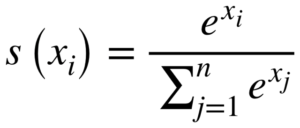

In [86]:
# 테스트 세트의 z1~z7값 구하기
decision = lr.decision_function(test_scaled[:5])
print(np.round(decision, decimals=2))

[[ -6.51   1.04   5.17  -2.76   3.34   0.35  -0.63]
 [-10.88   1.94   4.78  -2.42   2.99   7.84  -4.25]
 [ -4.34  -6.24   3.17   6.48   2.36   2.43  -3.87]
 [ -0.69   0.45   2.64  -1.21   3.26  -5.7    1.26]
 [ -6.4   -1.99   5.82  -0.13   3.5   -0.09  -0.7 ]]


In [87]:
from scipy.special import softmax
proba = softmax(decision, axis=1)
print(np.round(proba, decimals=3))

[[0.    0.014 0.842 0.    0.135 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.934 0.015 0.016 0.   ]
 [0.011 0.034 0.305 0.006 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


- decision 배열을 softmax() 함수에 전달
- softmax()의 axis 매개변수는 소프트맥스를 계산할 축 지정
- axis를 지정하지 않으면 배열 전체에 대해 소프트맥스 계산, axis=1이므로 각 행, 즉 각 샘플에 대해 소프트맥스 계산
- 계산 결과, proba 배열과 정확히 일치함